In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e1/sample_submission.csv
/kaggle/input/playground-series-s5e1/train.csv
/kaggle/input/playground-series-s5e1/test.csv
/kaggle/input/cbfitmodels/cbfit_Singapore
/kaggle/input/cbfitmodels/cbfit_Italy
/kaggle/input/cbfitmodels/cbfit_Finland
/kaggle/input/cbfitmodels/cbfit_Canada
/kaggle/input/cbfitmodels/cbfit_Norway
/kaggle/input/cbfitmodels/cbfit_Kenya
/kaggle/input/cbfitmodels/__results___files/__results___9_0.png
/kaggle/input/cbfitmodels/__results___files/__results___64_1.png
/kaggle/input/cbfitmodels/__results___files/__results___13_0.png
/kaggle/input/cbfitmodels/catboost_info/test_error.tsv
/kaggle/input/cbfitmodels/catboost_info/learn_error.tsv
/kaggle/input/cbfitmodels/catboost_info/catboost_training.json
/kaggle/input/cbfitmodels/catboost_info/time_left.tsv
/kaggle/input/cbfitmodels/catboost_info/learn/events.out.tfevents
/kaggle/input/cbfitmodels/catboost_info/test/events.out.tfevents


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import SplineTransformer


def periodic_spline_transformer(period, n_splines=None, degree=3):
    if n_splines is None:
        n_splines = period
    n_knots = n_splines + 1  # periodic and include_bias is True
    return SplineTransformer(
        degree=degree,
        n_knots=n_knots,
        knots=np.linspace(0, period, n_knots).reshape(n_knots, 1),
        extrapolation="periodic",
        include_bias=True,
    )

# Sample quarterly data
# data = {'quarter': [1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4],
#         'value': [10, 15, 12, 18, 11, 16, 13, 19, 12, 17, 14, 20]}
# df = pd.DataFrame(data)

# # Create periodic spline transformer
# qt = periodic_spline_transformer(12, 4)

# # Transform the 'quarter' feature
# quarter = qt.fit_transform(df_train[['Month']])[:,0]

# # Add transformed features to DataFrame
# print(quarter)

In [3]:
check_pg=[]

In [4]:
def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    check_pg.append(freqencies)
    check_pg.append(spectrum)
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    plt.savefig('pg.png')
    return ax

In [5]:
!pip install optuna-integration[catboost]
!pip install -U holidays

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.6/97.6 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 25.2 MB/s eta 0:00:00
  Attempting uninstall: holidays
    Found existing installation: holidays 0.57
    Uninstalling holidays-0.57:
      Successfully uninstalled holidays-0.57


In [6]:
!pip install -U pycountry

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 63.7 MB/s eta 0:00:00


In [7]:
import statsmodels

In [8]:
import pandas as pd
import numpy as np
import optuna
import catboost as cb
import matplotlib
import seaborn as sns
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from optuna.integration import CatBoostPruningCallback
import pycountry 
import holidays




In [9]:
df_train=pd.read_csv('/kaggle/input/playground-series-s5e1/train.csv')
df_test=pd.read_csv('/kaggle/input/playground-series-s5e1/test.csv')



In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230130 entries, 0 to 230129
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   id        230130 non-null  int64  
 1   date      230130 non-null  object 
 2   country   230130 non-null  object 
 3   store     230130 non-null  object 
 4   product   230130 non-null  object 
 5   num_sold  221259 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 10.5+ MB


In [11]:
df_train['store'].unique()

array(['Discount Stickers', 'Stickers for Less', 'Premium Sticker Mart'],
      dtype=object)

In [12]:
df_train[df_train['country']=='Kenya']['store'].unique()

array(['Discount Stickers', 'Stickers for Less', 'Premium Sticker Mart'],
      dtype=object)

In [13]:
df_train['product'].unique()

array(['Holographic Goose', 'Kaggle', 'Kaggle Tiers', 'Kerneler',
       'Kerneler Dark Mode'], dtype=object)

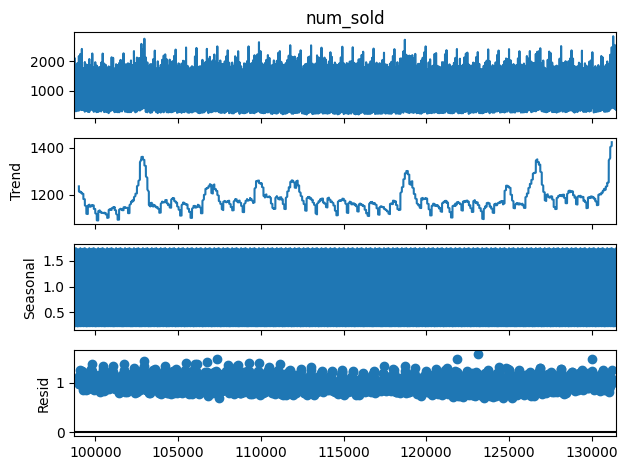

In [14]:
### import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Generate synthetic time series data
np.random.seed(42)
#df_train['date']=pd.to_datetime(df_train['date'])
#df_train=df_train.set_index('date')
df=df_train['num_sold']

#time = pd.date_range(start=df_train['date'].min, end=df_train['date'].max, periods=365, freq='D')
#series = 10 + 0.05 * np.arange(100) + np.sin(2 * np.pi * time.dayofyear / 365) + np.random.normal(0, 1, 100)
#df = pd.DataFrame({'date': time, 'value': series}).set_index('date')

# Decompose time series
decomposition = seasonal_decompose(
    df_train[(df_train['country']=='Singapore') & 
    (df_train['date'].str.contains('2013')) &
    (df_train['store']=='Premium Sticker Mart')]['num_sold'],
    model='multiplicative', period=30)  # Set period according to data frequency

# Plot components
decomposition.plot()
plt.show()


In [15]:
# temp=pd.concat([df_train['date'],df_train['num_sold']],axis=1)
# sumsale2016=temp.groupby('date').mean().squeeze().loc['2013']
# #sumsale2016
# plot_periodogram(sumsale2016)

In [16]:
from statsmodels.tsa.stattools import adfuller

# Perform ADF test
adf_result = adfuller(df_train[(df_train['country']=='Singapore') & (df_train['store']=='Discount Stickers')]['num_sold'])

# Print results
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
if adf_result[1] < 0.05:
    print("The series is stationary.")
else:
    print("The series is not stationary.")


ADF Statistic: -6.129147123657372
p-value: 8.484833374009022e-08
The series is stationary.


In [17]:
from statsmodels.tsa.stattools import kpss

# Perform KPSS test
kpss_result = kpss(df_train[(df_train['country']=='Singapore') & (df_train['store']=='Discount Stickers')]['num_sold'], regression='c')

# Print results
print("KPSS Statistic:", kpss_result[0])
print("p-value:", kpss_result[1])
if kpss_result[1] < 0.05:
    print("The series is not stationary (has a trend).")
else:
    print("The series is stationary.")

KPSS Statistic: 0.7976600279714846
p-value: 0.01
The series is not stationary (has a trend).


<ipython-input-17-b1e5399dac4b>:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(df_train[(df_train['country']=='Singapore') & (df_train['store']=='Discount Stickers')]['num_sold'], regression='c')


In [18]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230130 entries, 0 to 230129
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   id        230130 non-null  int64  
 1   date      230130 non-null  object 
 2   country   230130 non-null  object 
 3   store     230130 non-null  object 
 4   product   230130 non-null  object 
 5   num_sold  221259 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 10.5+ MB


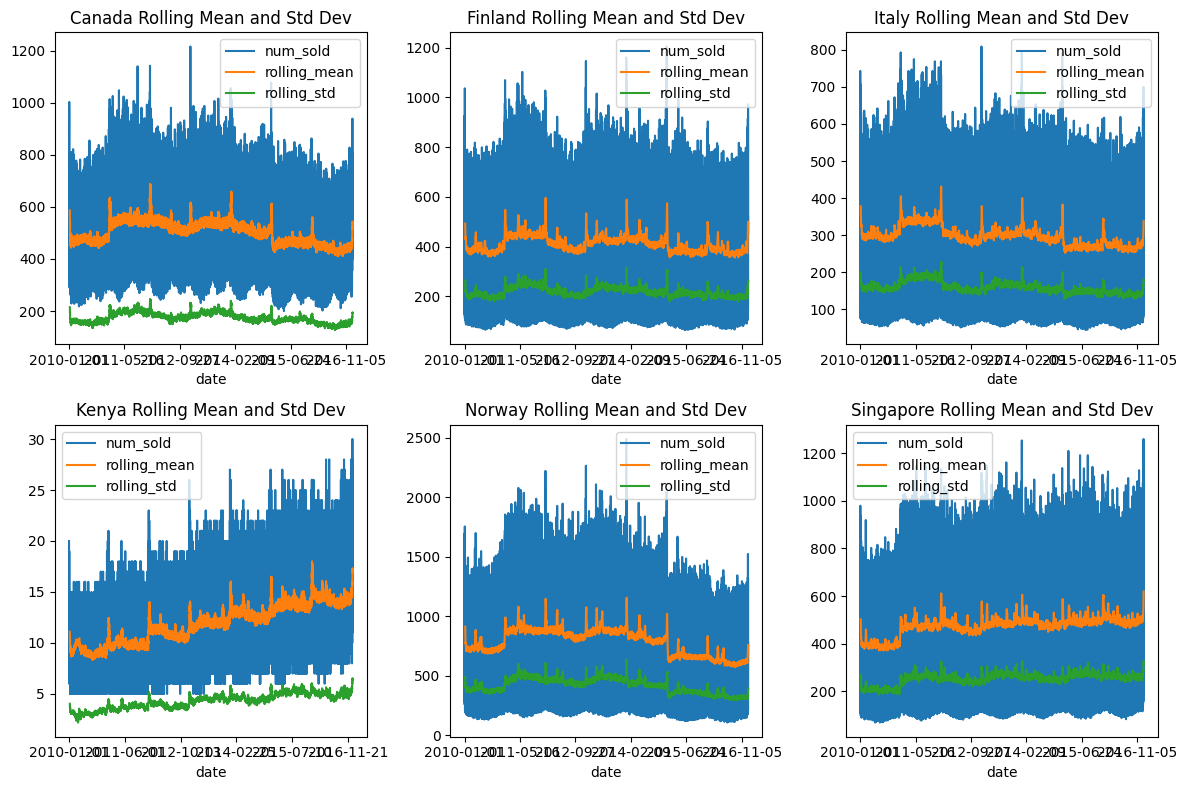

In [19]:
# Plot showing timeseries attributes: trend, seasonality 

# Create subplots: 2 rows, 3 columns
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# Flatten the axes array for easy iteration
axes = axes.flatten()
countrylist=df_train['country'].unique().tolist()
# Loop through each subplot and plot
for i, ax in enumerate(axes):
    df=df_train[(df_train['country']==countrylist[i]) & (df_train['store']=='Discount Stickers')][['date','num_sold']]
    df.dropna(inplace=True)
    df.set_index('date',inplace=True)
    df['rolling_mean'] = df['num_sold'].rolling(window=30).mean()
    df['rolling_std'] = df['num_sold'].rolling(window=30).std()
    df[['num_sold', 'rolling_mean', 'rolling_std']].plot(ax=ax,title=f'{countrylist[i]} Rolling Mean and Std Dev')

plt.tight_layout()

# Show the plot
plt.show()
    

In [20]:
test=df_train.dropna()
test[test['country']=='Kenya']['num_sold'].max

<bound method Series.max of 46        20.0
47        16.0
48         8.0
49         9.0
50         5.0
          ... 
230095    10.0
230096    72.0
230097    58.0
230098    33.0
230099    42.0
Name: num_sold, Length: 33730, dtype: float64>

In [21]:


def get_alpha2_code(country_name):
  """
  Gets the ISO 3166-1 Alpha-2 country code for the given country name.

  Args:
    country_name: The name of the country.

  Returns:
    The ISO 3166-1 Alpha-2 country code, or None if the country is not found.
  """
  try:
    country = pycountry.countries.search_fuzzy(country_name)[0]
    return country.alpha_2
  except LookupError:
    return None



In [22]:
# Function to create holiday sets for each country
def generate_country_holidays(countries, start_year, end_year):
    country_holidays = {}
    for country in countries:
        # Generate a holiday set for the range of years
        country_holidays[country] = holidays.CountryHoliday(country, years=range(start_year, end_year + 1)) 
    return country_holidays


In [23]:
df_train['Day']=pd.to_datetime(df_train['date']).dt.strftime("%d")
df_train['Month']=pd.to_datetime(df_train['date']).dt.strftime("%m")
df_train['Year']=pd.to_datetime(df_train['date']).dt.strftime("%Y")
df_train['Day_of_week']=pd.to_datetime(df_train['date']).dt.dayofweek
df_train['Week_No']=pd.to_datetime(df_train['date']).dt.isocalendar().week
df_train['is_weekend']=(df_train['Day_of_week']>=4).astype(int)
df_train['Quarter_Discrete'] = (df_train['Month'].astype(int) - 1) // 3 + 1
df_train['quarter_normalized'] = (df_train['Quarter_Discrete']-1)/3
df_train['month_normalized']=(df_train['Month'].astype(int)-1)/11
df_train['Month_Spline']=periodic_spline_transformer(12,4).fit_transform(df_train[['quarter_normalized']])[:,0]
df_train['Quarter_Spline']=periodic_spline_transformer(4,4).fit_transform(df_train[['quarter_normalized']])[:,0]
df_train['week_number_normalized'] = df_train['Week_No'] / df_train['Week_No'].max()
df_train['Week_Spline']=periodic_spline_transformer(53,5).fit_transform(df_train[['week_number_normalized']])[:,0]

In [24]:
def consecutive_days_visited(df):
    """
    Calculates the number of consecutive days a store was visited.

    Args:
        df: pandas DataFrame with columns 'date', 'country', 'store'

    Returns:
        pandas DataFrame with an additional column 'consecutive_days' 
    """

    # Ensure date index is sorted
    df = df.sort_index()

    # Group by 'country' and 'store'
    grouped = df.groupby(['country', 'store'])

    # Calculate consecutive days within each group
    df['consecutive_days'] = (grouped.indices - grouped.indices.min()).dt.days + 1

    return df


In [25]:
allcountries=df_train['country'].unique()
countrycodes = list(map(lambda x:get_alpha2_code(x),allcountries)) 
unique_countries = [cc for cc in countrycodes if cc is not None]
print(countrycodes)

['CA', 'FI', 'IT', 'KE', 'NO', 'SG']


In [26]:
df_train['store']=df_train['store'].astype('category')
df_train['country']=df_train['country'].astype('category')
df_train['product']=df_train['product'].astype('category')
df_train['Day']=df_train['Day'].astype('category')
df_train['Month']=df_train['Month'].astype('category')
df_train['Year']=df_train['Year'].astype('category')
df_train['Day_of_week']=df_train['Day_of_week'].astype('category')


In [27]:
df_test['Day']=pd.to_datetime(df_test['date']).dt.strftime("%d")
df_test['Month']=pd.to_datetime(df_test['date']).dt.strftime("%m")
df_test['Year']=pd.to_datetime(df_test['date']).dt.strftime("%Y")
df_test['Day_of_week']=pd.to_datetime(df_test['date']).dt.dayofweek
df_test['Week_No']=pd.to_datetime(df_test['date']).dt.isocalendar().week
df_test['is_weekend']=(df_test['Day_of_week']>=4).astype(int)
df_test['Quarter_Discrete'] = (df_test['Month'].astype(int) - 1) // 3 + 1
df_test['quarter_normalized'] = (df_test['Quarter_Discrete']-1)/3
df_test['month_normalized']=(df_test['Month'].astype(int)-1)/11
df_test['Month_Spline']=periodic_spline_transformer(12,4).fit_transform(df_test[['quarter_normalized']])[:,0]
df_test['Quarter_Spline']=periodic_spline_transformer(4,4).fit_transform(df_test[['quarter_normalized']])[:,0]
df_test['week_number_normalized'] = df_test['Week_No'] / df_test['Week_No'].max()
df_test['Week_Spline']=periodic_spline_transformer(53,5).fit_transform(df_test[['week_number_normalized']])[:,0]


In [28]:
df_test.drop(['week_number_normalized','month_normalized','quarter_normalized'],axis=1,inplace=True)

In [29]:
df_train.drop(['week_number_normalized','month_normalized','quarter_normalized'],axis=1,inplace=True)

In [30]:
df_test['store']=df_test['store'].astype('category')
df_test['country']=df_test['country'].astype('category')
df_test['product']=df_test['product'].astype('category')
df_test['Day']=df_test['Day'].astype('category')
df_test['Month']=df_test['Month'].astype('category')
df_test['Year']=df_test['Year'].astype('category')
df_test['Day_of_week']=df_test['Day_of_week'].astype('category')


In [31]:
df_train['date']=pd.to_datetime(df_train['date'])
df_test['date']=pd.to_datetime(df_test['date'])

In [32]:
df_train['previous_visit']=df_train.reset_index().groupby(by=['country','store'])[['date']].diff()

<ipython-input-32-a9a4f327ce0c>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_train['previous_visit']=df_train.reset_index().groupby(by=['country','store'])[['date']].diff()


In [33]:
df_train['consec_days']=df_train.groupby(by=['country','store'])[['previous_visit']].cumsum()

<ipython-input-33-9b789beb13f0>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_train['consec_days']=df_train.groupby(by=['country','store'])[['previous_visit']].cumsum()


In [34]:
df_test['previous_visit']=df_test.reset_index().groupby(by=['country','store'])[['date']].diff()
df_test['consec_days']=df_test.groupby(by=['country','store'])[['previous_visit']].cumsum()

<ipython-input-34-b64440241ea2>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_test['previous_visit']=df_test.reset_index().groupby(by=['country','store'])[['date']].diff()
<ipython-input-34-b64440241ea2>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_test['consec_days']=df_test.groupby(by=['country','store'])[['previous_visit']].cumsum()


In [35]:
df_train.set_index('date',inplace=True)
Startmin=df_train.index.min()
df_train['days_since_start'] = (df_train.index - Startmin).days

# Add cycle hints based on time 
df_train['sin_year'] = np.sin(2 * np.pi * df_train['days_since_start'] / 365)
df_train['cos_year'] = np.cos(2 * np.pi * df_train['days_since_start'] / 365)
df_train['sin_month'] = np.sin(2 * np.pi * df_train['days_since_start'] / 30)
df_train['cos_month'] = np.cos(2 * np.pi * df_train['days_since_start'] / 30)

df_test.set_index('date',inplace=True)
df_test['days_since_start'] = (df_test.index - Startmin).days

# Add cycle hints based on time 
df_test['sin_year'] = np.sin(2 * np.pi * df_test['days_since_start'] / 365)
df_test['cos_year'] = np.cos(2 * np.pi * df_test['days_since_start'] / 365)
df_test['sin_month'] = np.sin(2 * np.pi * df_test['days_since_start'] / 30)
df_test['cos_month'] = np.cos(2 * np.pi * df_test['days_since_start'] / 30)

df_train.reset_index(inplace=True)
df_test.reset_index(inplace=True)

In [36]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230130 entries, 0 to 230129
Data columns (total 23 columns):
 #   Column            Non-Null Count   Dtype          
---  ------            --------------   -----          
 0   date              230130 non-null  datetime64[ns] 
 1   id                230130 non-null  int64          
 2   country           230130 non-null  category       
 3   store             230130 non-null  category       
 4   product           230130 non-null  category       
 5   num_sold          221259 non-null  float64        
 6   Day               230130 non-null  category       
 7   Month             230130 non-null  category       
 8   Year              230130 non-null  category       
 9   Day_of_week       230130 non-null  category       
 10  Week_No           230130 non-null  UInt32         
 11  is_weekend        230130 non-null  int64          
 12  Quarter_Discrete  230130 non-null  int64          
 13  Month_Spline      230130 non-null  float64  

In [37]:
#Get country

#Get holidays for each country
#allcountries.append("weirdcountry")
country_holidays={}

#df_train['date']=pd.to_datetime(df_train['date'])
start_year = df_train['date'].dt.year.min()
end_year = df_train['date'].dt.year.max()

country_holidays = generate_country_holidays(unique_countries, start_year, end_year)
holiday_df = pd.DataFrame([
    {'date': date, 'country_code': country, 'country': cname}
    for country in unique_countries
    for date in country_holidays[country]
    for cname in [pycountry.countries.get(alpha_2=cc).name for cc in unique_countries]]
)
holiday_df['is_holiday'] = 1
holiday_df['date']=pd.to_datetime(holiday_df['date'])
holiday_df.drop('country_code',axis=1,inplace=True)

df_train = df_train.merge(holiday_df, on=['date', 'country'], how='left').fillna({'is_holiday': 0})

In [38]:
df_train[(df_train['country']=='Norway') & (df_train['store']=='Discount Stickers') & (df_train['previous_visit'].astype('int')>0)].consec_days.max

<bound method Series.max of 600         1 days
690         2 days
780         3 days
870         4 days
1020        5 days
            ...   
249360   2552 days
249450   2553 days
249540   2554 days
249630   2555 days
249720   2556 days
Name: consec_days, Length: 2769, dtype: timedelta64[ns]>

In [39]:
start_year = df_test['date'].dt.year.min()
end_year = df_test['date'].dt.year.max()
#unique_countries = [cc for cc in countrycodes if cc is not None]
country_holidays = generate_country_holidays(unique_countries, start_year, end_year)

holiday_df = pd.DataFrame([
    {'date': date, 'country_code': country, 'country': cname}
    for country in unique_countries
    for date in country_holidays[country]
    for cname in [pycountry.countries.get(alpha_2=cc).name for cc in unique_countries]]
)
holiday_df['is_holiday']=1
holiday_df['date']=pd.to_datetime(holiday_df['date'])
holiday_df.drop('country_code',axis=1,inplace=True)

df_test = df_test.merge(holiday_df, on=['date', 'country'], how='left').fillna({'is_holiday': 0})


In [40]:
df_test['is_holiday']=df_test['is_holiday'].astype(int)
df_test['is_holiday'].value_counts()

is_holiday
0    88290
1    18270
Name: count, dtype: int64

In [41]:
df_train.set_index('date',inplace=True)
#df_test.set_index('date',inplace=True)

In [42]:
#Graph for intrpolate is changing too much
#Not interpolate but just drop Na is better
#Interpolate missing num_sold

#df_train['date']=pd.to_datetime(df_train['date'])
#df = df_train.set_index('date')

# df_train = df_train.sort_values(by=['country', 'store', 'product', 'date'])

# # Impute NaN with interpolation (grouped by Country, Store, and Product)
# df_train['num_sold'] = df_train.groupby(['country', 'store', 'product'])['num_sold'].transform(
#     lambda group: group.interpolate(method='linear',limit=None,limit_direction='both').ffill().bfill()
# )
#df['num_sold'].isna().any()

In [43]:
#condition = (df.num_sold.notna()) & (df['country']=='Canada') & (df['store']=='Discount Stickers') & (df['product']=='Holographic Goose')
#df[condition]


In [44]:
##Get num_sold NaN product store and country
#t=df[df.num_sold.isna()].groupby(['country','store','product'])['product'].value_counts().to_dict()

In [45]:
#Country store and product that have NaN
# for  k,v in t.items():
#     if v!=0:
#         print(k,v)

In [46]:
#Find Holographic Goose num_sold in each country
nan_product = df_train[(df_train['product']=='Holographic Goose') & (df_train['num_sold'].notna())].groupby(['country'])['num_sold']
print("Mean")
print(nan_product.mean())
print("Median")
print(nan_product.median())
print("Mode")
print(nan_product.agg(pd.Series.mode))
print("Min")
print(nan_product.min())
print("Max")
print(nan_product.max())

Mean
country
Canada       242.974170
Finland      179.209850
Italy        129.627508
Kenya          5.800233
Norway       341.143664
Singapore    206.325646
Name: num_sold, dtype: float64
Median
country
Canada       235.0
Finland      190.0
Italy        137.0
Kenya          6.0
Norway       353.0
Singapore    219.0
Name: num_sold, dtype: float64
Mode
country
Canada       218.0
Finland       91.0
Italy         64.0
Kenya          5.0
Norway       171.0
Singapore    107.0
Name: num_sold, dtype: float64
Min
country
Canada       200.0
Finland       65.0
Italy         44.0
Kenya          5.0
Norway       105.0
Singapore     69.0
Name: num_sold, dtype: float64
Max
country
Canada       449.0
Finland      491.0
Italy        318.0
Kenya         11.0
Norway       908.0
Singapore    469.0
Name: num_sold, dtype: float64


Impute Canana NaN with 218.0 
Impute Kenya NaN with 5.0

In [47]:
df_train['previous_visit'].fillna(pd.to_timedelta(0),inplace=True)
df_train['consec_days'].fillna(pd.to_timedelta(0),inplace=True)
df_test['previous_visit'].fillna(pd.to_timedelta(0),inplace=True)
df_test['consec_days'].fillna(pd.to_timedelta(0),inplace=True)

df_train.dropna(inplace=True)
#df_test.dropna(inplace=True)

In [48]:
#Impute Canada with 218
#df.loc[df['country']=='Canada',['num_sold']]=df.loc[df['country']=='Canada',['num_sold']].fillna(218.0)

In [49]:
#Impute Kenya with 5
#df.loc[df['country']=='Kenya',['num_sold']]=df.loc[df['country']=='Kenya',['num_sold']].fillna(5.0)

In [50]:
# nsmode = df_train['num_sold'].mode()
# df_train['num_sold']=df_train['num_sold'].fillna(nsmode[0])

In [51]:
#Get date back to feature after interpolation
df_train=df_train.reset_index()

In [52]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240265 entries, 0 to 240264
Data columns (total 24 columns):
 #   Column            Non-Null Count   Dtype          
---  ------            --------------   -----          
 0   date              240265 non-null  datetime64[ns] 
 1   id                240265 non-null  int64          
 2   country           240265 non-null  object         
 3   store             240265 non-null  category       
 4   product           240265 non-null  category       
 5   num_sold          240265 non-null  float64        
 6   Day               240265 non-null  category       
 7   Month             240265 non-null  category       
 8   Year              240265 non-null  category       
 9   Day_of_week       240265 non-null  category       
 10  Week_No           240265 non-null  UInt32         
 11  is_weekend        240265 non-null  int64          
 12  Quarter_Discrete  240265 non-null  int64          
 13  Month_Spline      240265 non-null  float64  

In [53]:
df_train['is_holiday']=df_train['is_holiday'].astype('int')
df_train['previous_visit']=pd.to_numeric(df_train['previous_visit'].dt.days,errors='coerce')
df_train['consec_days']=pd.to_numeric(df_train['consec_days'].dt.days,errors='coerce')
df_train['country']=df_train['country'].astype('category')

df_test['is_holiday']=df_test['is_holiday'].astype('int')
df_test['previous_visit']=pd.to_numeric(df_test['previous_visit'].dt.days,errors='coerce')
df_test['consec_days']=pd.to_numeric(df_test['consec_days'].dt.days,errors='coerce')
df_test['country']=df_test['country'].astype('category')

In [54]:
#log transform target
df_train['num_sold']=np.log1p(df_train['num_sold']) 
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240265 entries, 0 to 240264
Data columns (total 24 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   date              240265 non-null  datetime64[ns]
 1   id                240265 non-null  int64         
 2   country           240265 non-null  category      
 3   store             240265 non-null  category      
 4   product           240265 non-null  category      
 5   num_sold          240265 non-null  float64       
 6   Day               240265 non-null  category      
 7   Month             240265 non-null  category      
 8   Year              240265 non-null  category      
 9   Day_of_week       240265 non-null  category      
 10  Week_No           240265 non-null  UInt32        
 11  is_weekend        240265 non-null  int64         
 12  Quarter_Discrete  240265 non-null  int64         
 13  Month_Spline      240265 non-null  float64       
 14  Quar

In [55]:
#dropping redundant features
df_train.drop(['Year','Quarter_Discrete','Week_No','days_since_start','Month_Spline'],axis=1,inplace=True)
df_test.drop(['Year','Quarter_Discrete','Week_No','days_since_start','Month_Spline'],axis=1,inplace=True)

In [56]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240265 entries, 0 to 240264
Data columns (total 19 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   date            240265 non-null  datetime64[ns]
 1   id              240265 non-null  int64         
 2   country         240265 non-null  category      
 3   store           240265 non-null  category      
 4   product         240265 non-null  category      
 5   num_sold        240265 non-null  float64       
 6   Day             240265 non-null  category      
 7   Month           240265 non-null  category      
 8   Day_of_week     240265 non-null  category      
 9   is_weekend      240265 non-null  int64         
 10  Quarter_Spline  240265 non-null  float64       
 11  Week_Spline     240265 non-null  float64       
 12  previous_visit  240265 non-null  int64         
 13  consec_days     240265 non-null  int64         
 14  sin_year        240265 non-null  flo

In [57]:
#Split data according to country into
from catboost import Pool
country_train_pool={}
country_valid_pool={}

for c in countrylist:
    df=df_train[df_train['country']==c]
    train_x, valid_x, train_y, valid_y = train_test_split(df.drop(['id','num_sold','country'],axis=1),df['num_sold'],shuffle=False,test_size=0.25)
    cats=df.select_dtypes('category').columns.to_list()
    cats.remove('country')
    cats.append('is_holiday')
    #cats.append('Week_No')
    cats.append('is_weekend')
    #cats.append('Quarter_Discrete')
    #train_weights = np.linspace(0.1, 1.0, len(train_x))
    #valid_weights = np.linspace(0.1, 1.0, len(valid_x)) # Linearly increasing weights
    # decay_rate=0.75
    # train_weights = decay_rate ** np.arange(len(train_x))[::-1]  # Exponentially increasing weights
    # valid_weights = decay_rate ** np.arange(len(valid_x))[::-1]  # Exponentially increasing weights
    country_train_pool[c]=Pool(train_x,label=train_y,cat_features=cats)#,weight=train_weights)
    country_valid_pool[c]=Pool(valid_x,label=valid_y,cat_features=cats)#,weight=valid_weights)
    #print(f"{c} train date {train_x['date'].min()} to {train_x['date'].max()}")
    print(f"{c} train loc  {train_x.index.min()} to {train_x.index.max()}")
    #print(f"{c} valid date {valid_x['date'].min()} to {valid_x['date'].max()}") 
    print(f"{c} valid loc {valid_x.index.min()} to {valid_x.index.max()}")

Canada train loc  0 to 177819
Canada valid loc 177820 to 240190
Finland train loc  84 to 180069
Finland valid loc 180070 to 240205
Italy train loc  174 to 180144
Italy valid loc 180145 to 240220
Kenya train loc  264 to 182812
Kenya valid loc 182813 to 240234
Norway train loc  348 to 180289
Norway valid loc 180290 to 240249
Singapore train loc  438 to 180364
Singapore valid loc 180365 to 240264


In [58]:
from functools import partial
from catboost import cv

def objective(trial: optuna.Trial, country) -> float:
    #data, target = load_breast_cancer(return_X_y=True)
    #train_x, valid_x, train_y, valid_y = train_test_split(df_train.drop(['id','num_sold','date'],axis=1), df_train['num_sold'], test_size=0.25)
    #cats=df_train.select_dtypes('category').columns
    
    param = {
        "iterations":trial.suggest_int("iterations",1000,10000),
        "learning_rate":trial.suggest_float("learning_rate",0.005,0.03,log=True),
        "objective": trial.suggest_categorical("objective", ["MAPE"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.7, log=True),
        "depth": trial.suggest_int("depth", 2, 10),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "used_ram_limit": "3gb",
        "eval_metric": "MAPE",
        "cat_features": cats,
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1, log=True)

   
    #use catboost cv with timeseries data
    cv_data = cb.cv(
        country_train_pool[c],
        params=param,
        shuffle=False,
        type='TimeSeries',
        fold_count=3,
        early_stopping_rounds=400,
        verbose=0,
    )
    mape = cv_data['test-MAPE-mean'].min()
    best_iter = cv_data['test-MAPE-mean'].values.argmin()
    # gbm = cb.CatBoostRegressor(**param)

    # pruning_callback = CatBoostPruningCallback(trial, "MAPE")
    # gbm.fit(
    #    # train_x,
    #    # train_y,
    #    # eval_set=[(valid_x, valid_y)],
    #     country_train_pool[c],
    #     eval_set=country_valid_pool[c],
    #     verbose=0,
    #     early_stopping_rounds=300,
    #     callbacks=[pruning_callback],
    # )

    # evoke pruning manually.
    #pruning_callback.check_pruned()

    
    #preds = gbm.predict(valid_x)
    #pred_labels = np.fix(preds)
    #mape = mean_absolute_percentage_error(valid_y, pred_labels)
    return mape


In [59]:
from functools import partial 

country_best_params={}
for c in countrylist:
    objective = partial(objective, country = c)
    
    optuna.logging.set_verbosity(optuna.logging.CRITICAL)
    study = optuna.create_study(
        #pruner=optuna.pruners.MedianPruner(n_warmup_steps=5), 
        direction="minimize",
    )
    study.optimize(objective, n_trials=100, timeout=600)
    
    print("Number of finished trials: {}".format(len(study.trials)))
    
    print(f'{c} Best trial:')
    trial = study.best_trial
    
    print("  Value: {}".format(trial.value))
    
    print(f"{c}  Params: ")
    country_best_params[c]=trial.params.copy()
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
        

Training on fold [0/3]

bestTest = 0.011530384
bestIteration = 7627

Training on fold [1/3]

bestTest = 0.01232808664
bestIteration = 7313

Training on fold [2/3]

bestTest = 0.0151555547
bestIteration = 4410

Training on fold [0/3]

bestTest = 0.06239186241
bestIteration = 1457

Training on fold [1/3]

bestTest = 0.03349613834
bestIteration = 775

Training on fold [2/3]

bestTest = 0.01605891596
bestIteration = 3329

Training on fold [0/3]

bestTest = 0.04029084312
bestIteration = 1207

Training on fold [1/3]

bestTest = 0.04368203527
bestIteration = 797

Training on fold [2/3]

bestTest = 0.03177327898
bestIteration = 1897

Training on fold [0/3]

bestTest = 0.07084436901
bestIteration = 2095

Training on fold [1/3]

bestTest = 0.07122159466
bestIteration = 2095

Training on fold [2/3]

bestTest = 0.06903369715
bestIteration = 2095

Training on fold [0/3]

bestTest = 0.03269639852
bestIteration = 1753

Training on fold [1/3]

bestTest = 0.0147310447
bestIteration = 735

Training on f

In [60]:
#print(study.best_params)

In [61]:
# from catboost import Pool,cv
# cats=df_train.select_dtypes('category').columns
# features=df_train.drop(['id','num_sold','date'],axis=1).columns
# train_pool = Pool(data=df_train.drop(['id','num_sold','date'],axis=1),
#              label=df_train['num_sold'],
#              cat_features=cats.to_list())

In [62]:
# from catboost import Pool,cv

#              #feature_names=features)


# # params = {"iterations": 1000,
# #           "depth": 4,
# #           "loss_function": "MAPE",
# #           "verbose": False}

# scores = cv(train_pool,
#             study.best_params,
#            fold_count=5,
#             verbose=0,
#            )

# print(scores)

In [63]:
#print(scores)

In [64]:
#hyperdict=optuna.importance.get_param_importances(study)

In [65]:
#print(hyperdict)

In [66]:
for p,v in country_best_params.items():
    print(p)
    print(v)

Canada
{'iterations': 8095, 'learning_rate': 0.012046953745476315, 'objective': 'MAPE', 'colsample_bylevel': 0.06257653518317376, 'depth': 6, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}
Finland
{'iterations': 8820, 'learning_rate': 0.024964817218200104, 'objective': 'MAPE', 'colsample_bylevel': 0.49038515624148005, 'depth': 2, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}
Italy
{'iterations': 5851, 'learning_rate': 0.028014379106439852, 'objective': 'MAPE', 'colsample_bylevel': 0.4785785878172028, 'depth': 2, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}
Kenya
{'iterations': 8484, 'learning_rate': 0.028278392372347524, 'objective': 'MAPE', 'colsample_bylevel': 0.40934895596204385, 'depth': 3, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.12028894242342357}
Norway
{'iterations': 3592, 'learning_rate': 0.021265656471484876, 'objective': 'MAPE', 'colsample_bylevel': 0.04053524344529136, 'depth': 3, 'boosting_type': 'Ordered', 'bootstrap_type': 

In [67]:
#Execute this cell in case of loading fitted model to do prediction
country_model={}
def LoadModel():
    Path='/kaggle/input/cbfitmodels'
    countrylist=['Canada','Finland','Italy','Kenya','Norway','Singapore']
    for c in countrylist:
        country_model[c]=cb.CatBoostRegressor().load_model(f'{Path}/cbfit_{c}')


In [68]:
#Use when using model without training
#LoadModel()

In [69]:
# country_best_params={}
# country_best_params['Canada']={'iterations': 3593, 'learning_rate': 0.012827192029471704, 'objective': 'MAPE', 'colsample_bylevel': 0.09122674054287529, 'depth': 3, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.3698567303900272}
# country_best_params['Finland']={'iterations': 4674, 'learning_rate': 0.021005624891915504, 'objective': 'MAPE', 'colsample_bylevel': 0.5784183002099044, 'depth': 2, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 5.782146139508431}
# country_best_params['Italy']={'iterations': 1398, 'learning_rate': 0.0251234589892742, 'objective': 'MAPE', 'colsample_bylevel': 0.049188944104342755, 'depth': 7, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}
# country_best_params['Kenya']={'iterations': 3924, 'learning_rate': 0.016615674668667934, 'objective': 'MAPE', 'colsample_bylevel': 0.4274609331782009, 'depth': 2, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 6.2645325168308865}
# country_best_params['Norway']={'iterations': 3851, 'learning_rate': 0.019929523358906295, 'objective': 'MAPE', 'colsample_bylevel': 0.07338903404462888, 'depth': 2, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}
# country_best_params['Singapore']={'iterations': 1094, 'learning_rate': 0.02694754587058969, 'objective': 'MAPE', 'colsample_bylevel': 0.554849569101183, 'depth': 3, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}

In [70]:
#Train model with best param and iteration>1000 before prediction
country_model={}
for c in countrylist:
    country_model[c]=cb.CatBoostRegressor(**country_best_params[c],verbose=0)
    country_model[c].fit(country_train_pool[c],eval_set=country_valid_pool[c])
    country_model[c].save_model(f'cbfit_{c}')
    print(f'{c} {country_model[c].get_best_score()}')
    print(f'{c} {country_model[c].get_feature_importance(prettified=True)}')

Canada {'learn': {'MAPE': 0.0069558398293019475}, 'validation': {'MAPE': 0.011632192163674344}}
Canada         Feature Id  Importances
0          product    38.986167
1            store    24.043843
2   previous_visit    16.587214
3      Day_of_week     3.289567
4            Month     3.203185
5             date     2.352680
6       is_weekend     1.954509
7              Day     1.924315
8      Week_Spline     1.179266
9         cos_year     1.173432
10        sin_year     1.067386
11     consec_days     1.001653
12      is_holiday     0.984699
13       cos_month     0.917477
14  Quarter_Spline     0.840486
15       sin_month     0.494121
Finland {'learn': {'MAPE': 0.0076473618643971}, 'validation': {'MAPE': 0.00961687786097859}}
Finland         Feature Id  Importances
0          product    45.198590
1            store    25.706713
2   previous_visit    24.027560
3         sin_year     1.445280
4      Day_of_week     0.754177
5         cos_year     0.707044
6            Month     0.590

In [71]:
country_model

{'Canada': <catboost.core.CatBoostRegressor at 0x7f1a963ccbe0>,
 'Finland': <catboost.core.CatBoostRegressor at 0x7f1a963cd780>,
 'Italy': <catboost.core.CatBoostRegressor at 0x7f1a9da3b040>,
 'Kenya': <catboost.core.CatBoostRegressor at 0x7f1a963cd270>,
 'Norway': <catboost.core.CatBoostRegressor at 0x7f1a9da3a530>,
 'Singapore': <catboost.core.CatBoostRegressor at 0x7f1a963ce920>}

<ipython-input-72-b533e4724463>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['num_sold']=country_predicts[c]
<ipython-input-72-b533e4724463>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rolling_mean'] = df['num_sold'].rolling(window=30).mean()
<ipython-input-72-b533e4724463>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

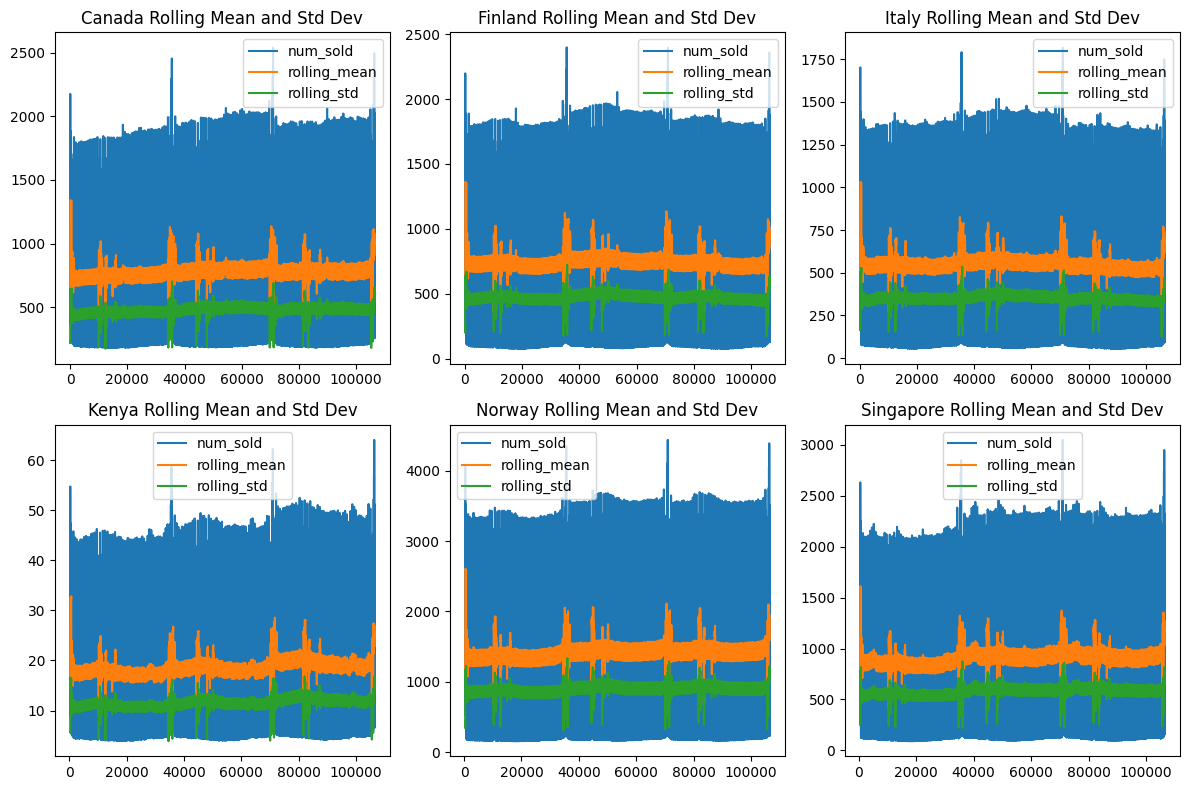

In [72]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
testcountrylist=df_test['country'].unique().tolist()
country_predicts={}
for i,c in enumerate(testcountrylist):
    df=df_test[df_test['country']==c]
    country_predicts[c] = np.expm1(country_model[c].predict(df.drop(['id','country'],axis=1)))
    df['num_sold']=country_predicts[c]
    df.set_index('date')
    df['rolling_mean'] = df['num_sold'].rolling(window=30).mean()
    df['rolling_std'] = df['num_sold'].rolling(window=30).std()
    df[['num_sold', 'rolling_mean', 'rolling_std']].plot(ax=axes.flat[i],title=f'{c} Rolling Mean and Std Dev')

plt.tight_layout()
plt.show()

In [73]:
cdf={}
for c in testcountrylist:
    cid=df_test[df_test['country']==c]['id']
    cdf[c]=pd.concat([cid.reset_index(drop=True),pd.DataFrame(np.round(country_predicts[c],0),columns=['num_sold'])],axis=1)
   

In [74]:
temp = pd.concat([df.reset_index(drop=True) for df in cdf.values()])

In [75]:
temp=temp.drop_duplicates()

In [76]:
temp.to_csv('submission_6country_dropna_spline_round2.csv',index=False)

In [77]:
cdf={}
for c in testcountrylist:
    cid=df_test[df_test['country']==c]['id']
    cdf[c]=pd.concat([cid.reset_index(drop=True),pd.DataFrame(np.fix(country_predicts[c]),columns=['num_sold'])],axis=1)

In [78]:
#pd.concat([df_test['id'],pd.DataFrame(np.round(predicts,0),columns=['num_sold'])],axis=1).reset_index(drop=True).to_csv('submission_impute_dropna_holidays_conseddays.csv',index=False)
temp = pd.concat([df.reset_index(drop=True) for df in cdf.values()])
temp=temp.drop_duplicates()
temp.to_csv('submission_6country_dropna_spline_fix2.csv',index=False)